# MRMS Reflectivity Animation: July 4, 2025

## Overview

#### This notebook walks through how to access, visualize, and animate low-level composite reflectivity data from the Multi-Radar/Multi-Sensor (MRMS) system.

The case study focuses on the Central Texas flood event in July 2025, using reflectivity data hosted on AWS. The main steps include:
- Selecting and downloading MRMS data for specific timestamps
- Creating a static reflectivity map
- Building an animation to show reflectivity changes over time

This notebook is intended for students, forecasters, or researchers looking to explore radar visualization techniques or build familiarity with remote sensing workflows using Python.

### What is MRMS?

The Multi-Radar/Multi-Sensor (MRMS) system is a set of real-time analysis products developed by NOAA’s National Severe Storms Laboratory (NSSL). It brings together data from:
- Dozens of NEXRAD radars
- Surface observations
- Satellites
- Lightning detection networks

to create high-resolution snapshots of precipitation, severe weather, and related hazards.

MRMS updates every 2.5 minutes and is commonly used in operational forecasting, hydrology, aviation, and research.

---

### Goal of This Notebook

The goal of this notebook is to walk through a simple, practical workflow for visualizing radar reflectivity data using Python. Specifically, we’ll:

- Access MRMS Layer Composite Reflectivity Low data from AWS Open Data
- Plot a single reflectivity frame as a static map
- Animate a 6-frame sequence from July 4, 2025, during the Central Texas flood event
- Demonstrate how to work with gridded radar data using open-source tools like MetPy, Cartopy, and xarray

## Imports
below are the python packages that are used for this code

In [95]:
# Core packages
import gzip
import tempfile

# File handling (if you're downloading MRMS .grib2.gz files manually)
import urllib.request
from datetime import datetime, timedelta
from io import StringIO

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmweather  # noqa: F401
import matplotlib.colors as mcolors

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import requests
import s3fs
import xarray as xr
from IPython.display import HTML  # To display the animation

# Animation
from matplotlib.animation import ArtistAnimation, PillowWriter
from metpy.plots import ctables  # For NWS reflectivity colormap
from scipy.interpolate import RegularGridInterpolator



## Define Timestamps and Colormap

To build the animation, we’ll use 6 hourly frames of MRMS data from the morning of July 4, 2025. Each timestamp matches a GRIB2 file available from the AWS MRMS archive.

We also define the standard NWS reflectivity colormap using MetPy, which gives us consistent color breaks every 5 dBZ which is a common setup for radar reflectivity plots.

### Access and Load MRMS Data

MRMS data is stored as .grib2.gz files on the AWS S3 public data bucket. Each file represents a single timestamp and product type.

In this step:
- We use urllib.request.urlopen() to **download the compressed file** directly from AWS
- We **decompress** it using Python’s built-in gzip module
- Then we load the GRIB2 file into an xarray.DataArray using the cfgrib engine

This approach lets us work with the data directly in Python without having to manually download or unzip anything ahead of time.

In [2]:
# Define the URL to the compressed MRMS GRIB2 file for a specific timestamp
url = "https://noaa-mrms-pds.s3.amazonaws.com/CONUS/LayerCompositeReflectivity_Low_00.50/20250704/MRMS_LayerCompositeReflectivity_Low_00.50_20250704-001040.grib2.gz"

# Download the file as bytes
response = urllib.request.urlopen(url)
compressed_file = response.read()

# Decompress and load into xarray using a temporary file
with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
    # Decompress the .gz content and write to temp file
    f.write(gzip.decompress(compressed_file))

    # Load GRIB2 data as an xarray DataArray
    data_in = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


## Set Up Reflectivity Colormap and Extract Data

This section gets the MRMS reflectivity data ready for plotting and builds a map to visualize it.

- **Colormap and Normalization:**  
  We use MetPy’s built-in NWSReflectivity colormap, which is designed for radar data in dBZ. The get_with_steps() function sets up color breaks every 5 dBZ — a common setup in operational radar displays.

- **Extract Coordinates and Data:**  
  We pull out the longitude, latitude, and reflectivity values from the data array. If the coordinates are in 1D (which happens in some MRMS products), we convert them to 2D using np.meshgrid() so they work with the plotting function.

- **Mask Low Reflectivity Values:**  
  Reflectivity values below 5 dBZ are masked out with ma.masked_where() to remove light noise and clutter from the map.

- **Set Up the Map:**  
  We create a static figure using matplotlib and Cartopy, with a PlateCarree projection centered over Texas. The domain is narrowed with set_extent() to focus on the region of interest.

- **Add Map Features:**  
  Coastlines, country borders, and U.S. state lines are added to give the plot geographic context.

- **Plot the Reflectivity:**  
  The reflectivity field is plotted using pcolormesh() with our defined colormap and normalization. A horizontal colorbar is added to show the dBZ scale.

- **Final Touches:**  
  We include a plot title and display the final figure with plt.show().

In [3]:
refl_norm, refl_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

# 2. Extract coords & data
lons = data_in.longitude.values
lats = data_in.latitude.values
refl = data_in.values

# If coords are 1D, make them 2D
if lons.ndim == 1 and lats.ndim == 1:
    lons, lats = np.meshgrid(lons, lats)

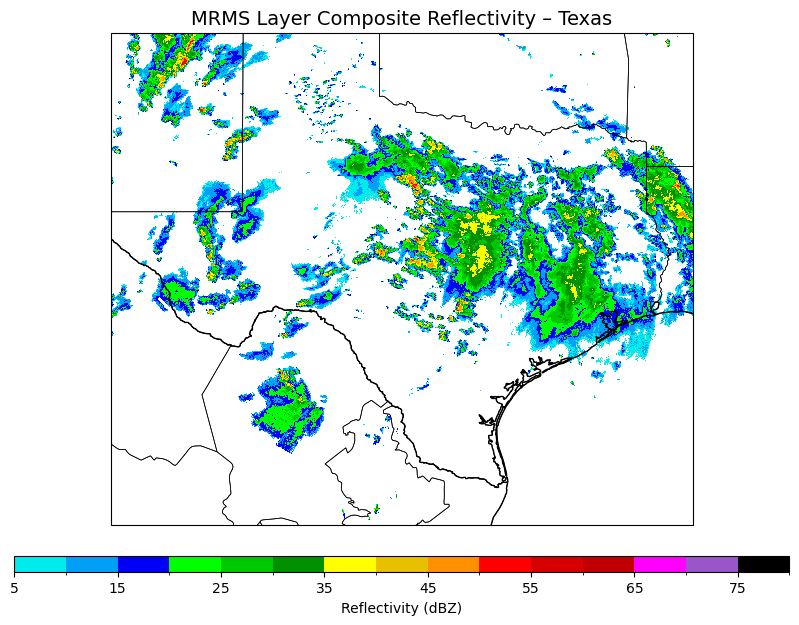

In [4]:
# 3. Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106, -93, 25, 36], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linewidth=0.5)

mesh = ax.pcolormesh(
    lons, lats, ma.masked_where(refl<5,refl),
    cmap=refl_cmap,
    norm=refl_norm,
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cb.set_label('Reflectivity (dBZ)')

plt.title('MRMS Layer Composite Reflectivity – Texas', fontsize=14)
plt.show()


### Select Timestamps and Animate Reflectivity

This part of the notebook automates the process of pulling in multiple MRMS reflectivity files and creating an animation to show how low-level reflectivity changed over time.

- **Check for Available Timestamps:**  
  We define a time range from July 4 to July 7, 2025, and loop through it in 30-minute steps. For each time, we generate a file path from the AWS-hosted MRMS archive and try downloading it. If the file exists, we save that timestamp. For this demo, we stop after grabbing six valid files.

- **Set Up the Map and Colormap:**  
  After collecting the timestamps, we build a static map using Cartopy (Plate Carree projection), focused on Texas and surrounding areas. We also apply the MetPy NWSReflectivity colormap and mask out any reflectivity values below 5 dBZ to clean up the visualization.

- **Download and Plot Each Frame:**  
  For each timestamp:
  - The corresponding .grib2.gz file is downloaded and decompressed.
  - We extract the reflectivity data and coordinates using xarray.
  - If the coordinate arrays are 1D, we convert them to 2D for plotting.
  - The reflectivity data is plotted with pcolormesh(), and we add a dynamic title showing the UTC time.
  - Each frame (plot + title) is saved for the animation.

- **Build the Animation:**  
  We use ArtistAnimation from Matplotlib to stitch the frames together into an animation. plt.close(fig) is used beforehand to prevent Jupyter from displaying a static image under the animation.

- **Export as a GIF:**  
  The finished animation is saved as a .gif using Pillow so it can be easily shared or embedded in a presentation.

The result is a short radar loop showing how reflectivity evolved during the early hours of July 4, 2025, which is a period tied to widespread heavy rain and flash flooding across Central Texas.

In [ ]:
start = datetime(2025, 7, 4, 0, 10, 40)
end = datetime(2025, 7, 7, 0, 0, 0)
step = timedelta(minutes=30)

valid_timestamps = []
t = start

print("Checking for available MRMS files...\n")

while t <= end and len(valid_timestamps) < 6:
    ts = t.strftime("%Y%m%d-%H%M%S")
    date_str = ts[:8]
    url = (
        f"https://noaa-mrms-pds.s3.amazonaws.com/CONUS/LayerCompositeReflectivity_Low_00.50/"
        f"{date_str}/MRMS_LayerCompositeReflectivity_Low_00.50_{ts}.grib2.gz"
    )
    try:
        resp = urllib.request.urlopen(url, timeout=5)
        print(f" Found: {ts}")
        valid_timestamps.append(ts)
    except:
        print(f" Missing: {ts}")
    t += step

print("\n Selected 6 timestamps:")
for ts in valid_timestamps:
    print(ts)


Checking for available MRMS files...

 Found: 20250704-001040
 Missing: 20250704-004040
 Found: 20250704-011040
 Missing: 20250704-014040
 Missing: 20250704-021040
 Missing: 20250704-024040
 Found: 20250704-031040
 Missing: 20250704-034040
 Missing: 20250704-041040
 Missing: 20250704-044040
 Missing: 20250704-051040
 Found: 20250704-054040
 Missing: 20250704-061040
 Missing: 20250704-064040
 Found: 20250704-071040
 Missing: 20250704-074040
 Missing: 20250704-081040
 Missing: 20250704-084040
 Found: 20250704-091040

 Selected 6 timestamps:
20250704-001040
20250704-011040
20250704-031040
20250704-054040
20250704-071040
20250704-091040


In [7]:
# Define the 6 known working timestamps (one every hour)
timestamps = [
    "20250704-001040",
    "20250704-011040",
    "20250704-031040",
    "20250704-054040",
    "20250704-071040",
    "20250704-091040"
]

# Set up colormap and normalization for reflectivity
refl_norm, refl_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

# Initialize animation container
frames_six = []

# Set up static map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106, -93, 25, 36], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Loop through timestamps and collect frames
for ts in timestamps:
    print(f"Loading {ts}...")
    try:
        url = (
            f"https://noaa-mrms-pds.s3.amazonaws.com/CONUS/LayerCompositeReflectivity_Low_00.50/"
            f"{ts[:8]}/MRMS_LayerCompositeReflectivity_Low_00.50_{ts}.grib2.gz"
        )
        response = urllib.request.urlopen(url)
        compressed_file = response.read()

        with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
            f.write(gzip.decompress(compressed_file))
            f.flush()
            data_in = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

        # Extract coordinates and reflectivity data
        lons = data_in.longitude.values
        lats = data_in.latitude.values
        refl = data_in.values

        if lons.ndim == 1 and lats.ndim == 1:
            lons, lats = np.meshgrid(lons, lats)

        # Plot single frame (no show)
        mesh = ax.pcolormesh(
            lons, lats, ma.masked_where(refl < 5, refl),
            cmap=refl_cmap,
            norm=refl_norm,
            transform=ccrs.PlateCarree()
        )

        # Create a title text that updates with each frame
        timestamp_label = f"{ts[:4]}-{ts[4:6]}-{ts[6:8]} {ts[9:11]}:{ts[11:13]} UTC"
        title = ax.text(
            0.5, 1.02,
            f"MRMS Low-Level Reflectivity (dBZ) – {timestamp_label}",
            transform=ax.transAxes,
            ha="center", va="bottom", fontsize=14
        )

        # Save both mesh and title to animation frame
        frames_six.append([mesh, title])

    except Exception as e:
        print(f"Skipped {ts} → {e}")
        continue

# Create and display an animation
plt.close(fig)
anim = ArtistAnimation(fig, frames_six, interval=500, blit=True)
HTML(anim.to_jshtml())

Loading 20250704-001040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-011040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-031040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-054040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-071040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


Loading 20250704-091040...


ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored
ECCODES ERROR   :  Key dataTime (unpack_long): Truncating time: non-zero seconds(40) ignored


In [ ]:
# Save animation as a .gif
anim.save("mrms_reflectivity_animation.gif", writer=PillowWriter(fps=2))

print("Animation saved as 'mrms_reflectivity_animation.gif'")


Animation saved as 'mrms_reflectivity_animation.gif'


## Reflectivity Animation: Summary

We demonstrated how to access and animate low-level composite reflectivity data from the MRMS system using open-source Python tools. We focused on a short sequence from the July 4, 2025, Central Texas flood event to highlight how reflectivity features evolved.

This workflow is a flexible starting point for working with radar data, especially for case studies or quick visual diagnostics. The next section will continue building on this analysis with more approaches to explore the MRMS dataset!

## Comparison with ASOS Data

In [96]:

aws = s3fs.S3FileSystem(anon=True)
path = aws.ls("noaa-mrms-pds/CONUS/RadarOnly_QPE_24H_00.00/20250705/")[0]

response = urllib.request.urlopen("https://noaa-mrms-pds.s3.amazonaws.com/" + path[14:])
compressed_file = response.read()

with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
            f.write(gzip.decompress(compressed_file))
            f.flush()
            data = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

# Set lat and lon bounds
lat_min, lat_max = 28, 33
lon_min, lon_max = -102.5, -96.5

# Subset data and delete original
subset = data.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(360 - abs(lon_min), 360 - abs(lon_max)),
).copy(deep=True)

# Remove original data to free memory
del data

url = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py"

params = {
    "network": "TX_ASOS",  # Or just use "ASOS" for all U.S.
    "data": "p01i",
    "year1": "2025",
    "month1": "7",
    "day1": "4",
    "year2": "2025",
    "month2": "7",
    "day2": "4",
    "format": "comma",
    "latlon": "yes",
}

# Make the request
response = requests.get(url, params=params)

# Parse CSV from response text
df = pd.read_csv(StringIO(response.text), skiprows=5)

# Drop missing precip values
df = df[df["p01i"] != "M"]
df["p01i"] = df["p01i"].astype(float)

# Convert timestamp to datetime
df["valid"] = pd.to_datetime(df["valid"])

# Group by station and sum hourly precip
daily_precip = (
    df.groupby(["station", "lon", "lat"])["p01i"]
    .sum()
    .reset_index()
    .rename(columns={"p01i": "precip_in"})
)

daily_precip

,station,lon,lat,precip_in
0,0F2,-97.7756,33.6017,0.1200
1,11R,-96.3742,30.2189,0.0200
2,18H,-92.0333,26.1283,0.0000
3,2R9,-97.8656,28.8250,0.0000
4,3T5,-96.9500,29.9100,0.0002
...,...,...,...,...
196,UVA,-99.7436,29.2113,0.0500
197,VAF,-94.6253,27.3536,0.0000
198,VCT,-96.9303,28.8614,0.0000
199,VHN,-104.7838,31.0578,0.0000


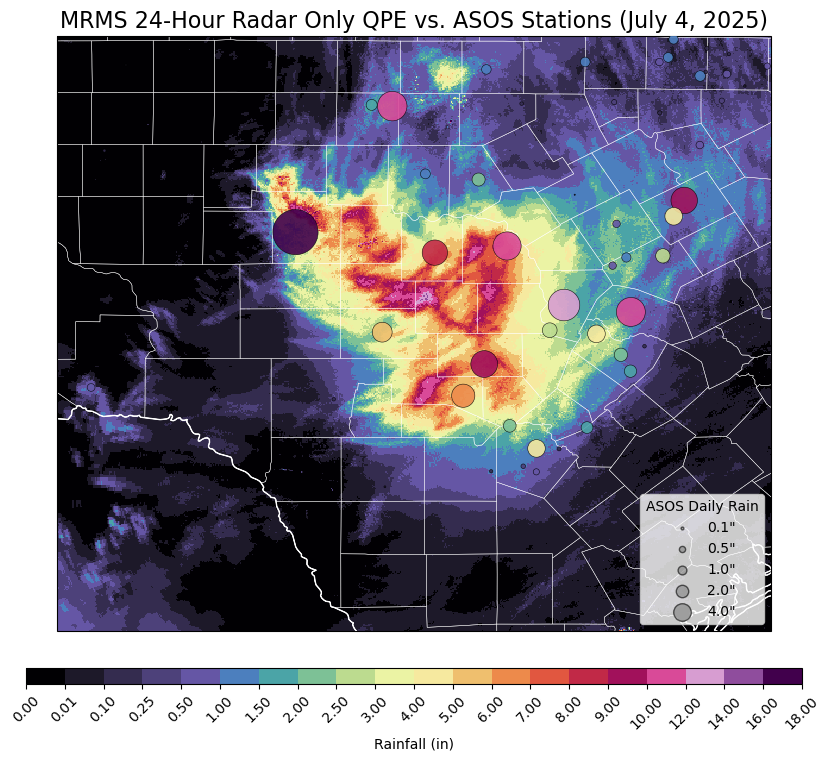

In [97]:
# Set levels
levels = [
    0,
    0.01,
    0.1,
    0.25,
    0.50,
    1,
    1.5,
    2,
    2.5,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    12,
    14,
    16,
    18,
]

# Create a normalization object
cmap = plt.get_cmap("ChaseSpectral")  # Use full-resolution colormap
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="white")
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor="white")
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
# Add counties
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_2_counties",
        scale="10m",
        facecolor="none",
        edgecolor="white",
        linewidth=0.3,
    )
)

mesh = ax.pcolormesh(
    subset.longitude,
    subset.latitude,
    subset / 25.4,  # Convert mm to inches
    norm=norm,
    cmap="ChaseSpectral",
    transform=ccrs.PlateCarree(),
)

# Overlay ASOS bubble plot
sc = ax.scatter(
    daily_precip["lon"],
    daily_precip["lat"],
    s=daily_precip["precip_in"] * 40,  # adjust bubble size scaling
    c=daily_precip["precip_in"],
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolor="black",
    linewidth=0.4,
    transform=ccrs.PlateCarree(),
    zorder=10
)

for size in [0.1, 0.5, 1.0, 2.0, 4.0]:
    ax.scatter([], [], s=size * 40, c='gray', alpha=0.6, edgecolor='black', label=f"{size:.1f}\"")

ax.legend(scatterpoints=1, loc="lower right", title="ASOS Daily Rain", frameon=True)


cb = plt.colorbar(
    mesh, ax=ax, orientation="horizontal", pad=0.05, aspect=50, shrink=0.8
)
cb.set_label("Rainfall (in)")
# Add tick labels to colorbar
cb.set_ticks(levels)
cb.set_ticklabels([f"{level:.2f}" for level in levels])
cb.ax.tick_params(labelsize=10, rotation=45)

plt.title("MRMS 24-Hour Radar Only QPE vs. ASOS Stations (July 4, 2025)", fontsize=16)
plt.tight_layout()

In [98]:
# Convert lat/lon coordinates from MRMS subset
lats = subset.latitude.values
lons = subset.longitude.values

# Ensure correct orientation (ascending order for interpolator)
if lats[0] > lats[-1]:
    lats = lats[::-1]
    subset = subset[::-1, :]

# Create interpolator (convert to inches)
interp_func = RegularGridInterpolator(
    (lats, lons), (subset / 25.4).values, bounds_error=False, fill_value=np.nan
)

# Convert ASOS longitude from degrees west to degrees east (0–360)
daily_precip["lon_east"] = daily_precip["lon"].apply(lambda x: x if x >= 0 else 360 + x)

station_coords = list(zip(daily_precip["lat"], daily_precip["lon_east"]))
daily_precip["mrms_in"] = interp_func(station_coords)


daily_precip["bias"] = daily_precip["precip_in"] - daily_precip["mrms_in"]


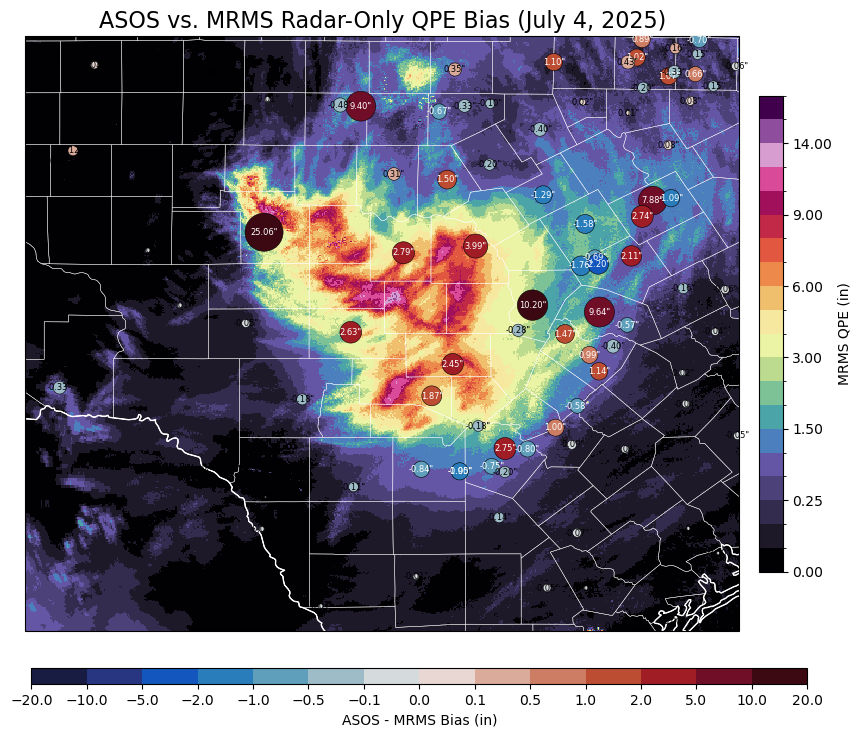

In [99]:
# Compute bias normalization
vmax = np.nanmax(np.abs(daily_precip["bias"]))

# Define bias levels (nonlinear, symmetric)
bias_levels = [-20, -10, -5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5, 10, 20]

# Create BoundaryNorm
norm_bias = mcolors.BoundaryNorm(bias_levels, ncolors=plt.get_cmap("balance").N, clip=True)


# Compute scatter sizes based on bias magnitude (optional scaling factor)
sizes = np.sqrt(np.abs(daily_precip["bias"])) * 150  # tweak 100 as needed

# Create figure and axis
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Basemap features
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="white")
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor="white")
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
ax.add_feature(
    cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_2_counties",
        scale="10m",
        facecolor="none",
        edgecolor="white",
        linewidth=0.3,
    )
)

# Pcolormesh for MRMS
mesh = ax.pcolormesh(
    subset.longitude,
    subset.latitude,
    subset / 25.4,  # Convert mm to inches
    norm=norm,
    cmap="ChaseSpectral",
    transform=ccrs.PlateCarree(),
)

sc = ax.scatter(
    daily_precip["lon"],
    daily_precip["lat"],
    c=daily_precip["bias"],
    s=sizes,
    cmap="balance",  # cmocean or any diverging colormap
    norm=norm_bias,
    edgecolor="black",
    linewidth=0.4,
    transform=ccrs.PlateCarree(),
    zorder=10,
)

# Add text labels for each station's bias
for _, row in daily_precip.iterrows():
    bias_val = row["bias"]
    if not np.isnan(bias_val):
        ax.text(
            row["lon"], row["lat"],
            f"{bias_val:.2f}\"",
            fontsize=6,
            ha="center", va="center",
            transform=ccrs.PlateCarree(),
            zorder=11,
            color="white" if abs(bias_val) > 0.5 else "black",  # adjust for contrast
        )



# Bias colorbar (scatter)
cb1 = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8, aspect=50)
cb1.set_label("ASOS - MRMS Bias (in)")
cb1.set_ticks(bias_levels)
cb1.ax.tick_params(labelsize=10)



# Add second colorbar (MRMS QPE from pcolormesh)
cb2 = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
cb2.set_label("MRMS QPE (in)")
cb2.ax.tick_params(labelsize=10)

# Title and layout
ax.set_title("ASOS vs. MRMS Radar-Only QPE Bias (July 4, 2025)", fontsize=16)
plt.tight_layout()


## Compare MRMS Radar-Only to Pass 1 and Pass 2 QPE

In [100]:
def load_mrms_qpe_24h(date_str, product="RadarOnly_QPE_24H_00.00",
                      lat_bounds=(28, 33), lon_bounds=(-102.5, -96.5)):
    """
    Loads and subsets MRMS 24-hour radar-only QPE data from AWS.

    Parameters:
    ----------
    date_str : str
        Date in 'YYYYMMDD' format (e.g., '20250705')
    product : str
        MRMS product folder (default: 'RadarOnly_QPE_24H_00.00' for Pass1)
    lat_bounds : tuple
        Tuple of (lat_min, lat_max)
    lon_bounds : tuple
        Tuple of (lon_min, lon_max) in degrees west

    Returns:
    -------
    subset : xarray.DataArray
        Subset of MRMS QPE field for given domain and date
    """

    # Access file listing on AWS
    aws = s3fs.S3FileSystem(anon=True)
    mrms_path = f"noaa-mrms-pds/CONUS/{product}/{date_str}/"
    file_list = aws.ls(mrms_path)

    # Only grab the first GRIB2 file for the day (should end in 0000.grib2.gz)
    grib_path = next((f for f in file_list if f.endswith(".grib2.gz")), None)
    if grib_path is None:
        raise FileNotFoundError(f"No GRIB2 file found for {date_str} in {product}")

    url = "https://noaa-mrms-pds.s3.amazonaws.com/" + grib_path[len("noaa-mrms-pds/"):]
    response = urllib.request.urlopen(url)
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(compressed_file))
        f.flush()
        data = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

    # Subset domain
    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds
    subset = data.sel(
        latitude=slice(lat_max, lat_min),
        longitude=slice(360 - abs(lon_min), 360 - abs(lon_max)),
    ).copy(deep=True)

    # Clean up
    del data

    return subset

In [101]:
subset_pass1 = load_mrms_qpe_24h("20250705", product="MultiSensor_QPE_24H_Pass1_00.00")
subset_pass2 = load_mrms_qpe_24h("20250705", product="MultiSensor_QPE_24H_Pass2_00.00")

/tmp/ipykernel_13983/732490426.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.25, 1, 0.98])  # leave space for suptitle and colorbar


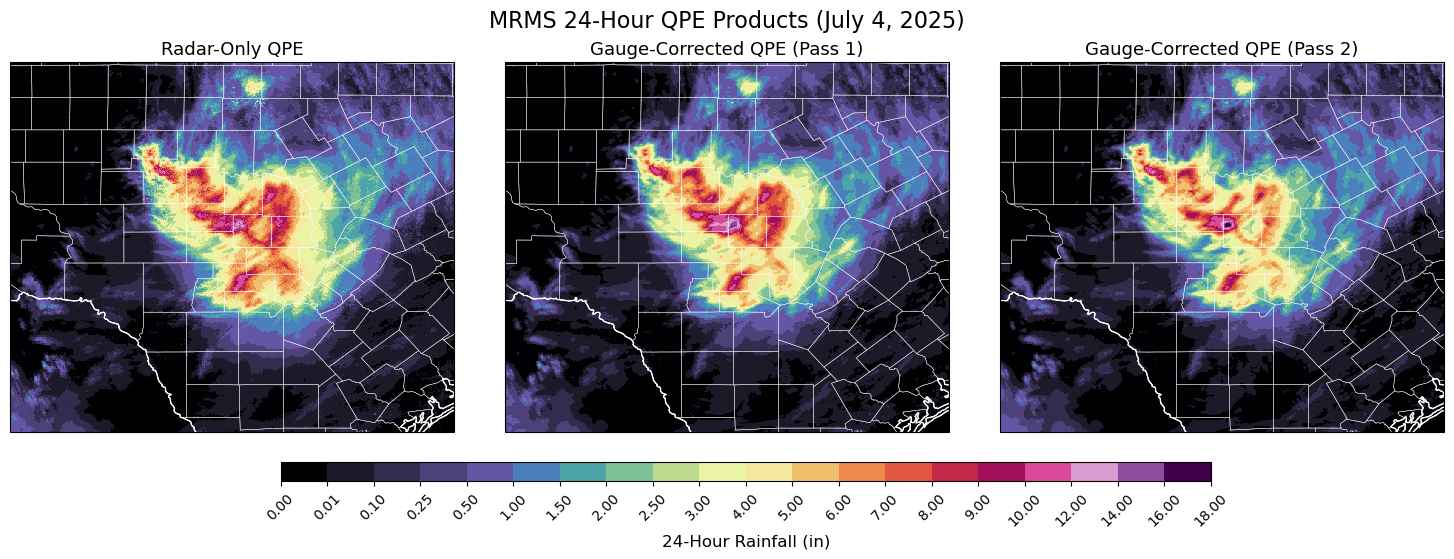

In [102]:
# Define levels and normalization
levels = [
    0, 0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5,
    3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18
]
cmap = plt.get_cmap("ChaseSpectral")
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

# Create figure and subplots
fig, axes = plt.subplots(
    1, 3, figsize=(15, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Title mapping
titles = [
    "Radar-Only QPE",
    "Gauge-Corrected QPE (Pass 1)",
    "Gauge-Corrected QPE (Pass 2)"
]

# Loop through datasets and plot
for ax, data, title in zip(
    axes,
    [subset, subset_pass1, subset_pass2],
    titles
):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Basemap features
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="white")
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor="white")
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            category="cultural",
            name="admin_2_counties",
            scale="10m",
            facecolor="none",
            edgecolor="white",
            linewidth=0.3,
        )
    )

    # Pcolormesh plot
    mesh = ax.pcolormesh(
        data.longitude,
        data.latitude,
        data / 25.4,  # mm to inches
        norm=norm,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
    )

    ax.set_title(title, fontsize=13)

# Shared colorbar below all plots
cb = fig.colorbar(
    mesh, ax=axes, orientation="horizontal", pad=0.08, aspect=50, shrink=0.8
)
cb.set_label("24-Hour Rainfall (in)", fontsize=12)
cb.set_ticks(levels)
cb.set_ticklabels([f"{level:.2f}" for level in levels])
cb.ax.tick_params(labelsize=10, rotation=45)

plt.suptitle("MRMS 24-Hour QPE Products (July 4, 2025)", fontsize=16)
plt.tight_layout(rect=[0, 0.25, 1, 0.98])  # leave space for suptitle and colorbar
plt.show()


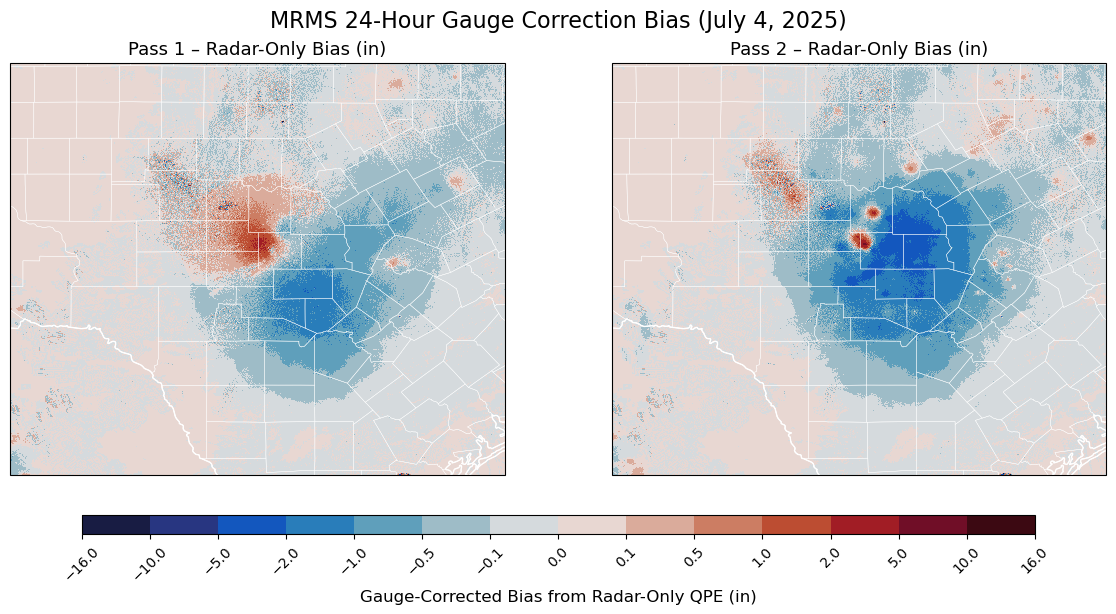

In [103]:
# Compute differences in inches
bias_pass1 = (subset_pass1 - subset) / 25.4
bias_pass2 = (subset_pass2 - subset) / 25.4

# Define nonlinear boundaries for bias (symmetric)
bias_levels = [-16, -10, -5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5, 10, 16]
norm_bias = mcolors.BoundaryNorm(bias_levels, ncolors=plt.get_cmap("balance").N, clip=True)

# Create figure and subplots
fig, axes = plt.subplots(
    1, 2, figsize=(12, 6), constrained_layout=True,
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Titles
titles = [
    "Pass 1 – Radar-Only Bias (in)",
    "Pass 2 – Radar-Only Bias (in)"
]

# Loop through plots
for ax, bias_data, title in zip(
    axes,
    [bias_pass1, bias_pass2],
    titles
):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Basemap features
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="white")
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor="white")
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            category="cultural",
            name="admin_2_counties",
            scale="10m",
            facecolor="none",
            edgecolor="white",
            linewidth=0.3,
        )
    )

    # Pcolormesh
    mesh = ax.pcolormesh(
        bias_data.longitude,
        bias_data.latitude,
        bias_data,
        cmap="balance",  # diverging colormap
        norm=norm_bias,
        transform=ccrs.PlateCarree(),
    )

    ax.set_title(title, fontsize=13)

# Shared colorbar
cb = fig.colorbar(
    mesh, ax=axes, orientation="horizontal", pad=0.08, aspect=50, shrink=0.8
)
cb.set_label("Gauge-Corrected Bias from Radar-Only QPE (in)", fontsize=12)
cb.set_ticks(bias_levels)
cb.ax.tick_params(labelsize=10, rotation=45)

# Suptitle and layout
plt.suptitle("MRMS 24-Hour Gauge Correction Bias (July 4, 2025)", fontsize=16)
plt.show()
